In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from functions.datasets import get_loaders
from functions.drawing import save_images_with_bboxes
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
dataset, train_loader, valid_loader, test_loader = get_loaders(
    os.path.join("data", "images"),
    os.path.join("data", "coco_annotations.json")
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
cuda


In [6]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = self._initialize_fc1()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._run_first_layers(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

    def _initialize_fc1(self) -> nn.Linear:
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 200)
            x = self._run_first_layers(dummy_input)
            input_size = x.size(1)
            
            return nn.Linear(input_size, 128)
        
    def _run_first_layers(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        
        return x

In [7]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()
            
            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.56it/s, Train Loss=19.1] 


Epoch 1, Loss: 19.06278101314198


Epoch 1/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.72it/s, Val Loss=15.1]  


Validation Loss: 15.080572232333097


Epoch 2/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.70it/s, Train Loss=10.4]  


Epoch 2, Loss: 10.35502520908009


Epoch 2/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.83it/s, Val Loss=9.39]  


Validation Loss: 9.393505133282055


Epoch 3/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.73it/s, Train Loss=8.96]  


Epoch 3, Loss: 8.958797985857183


Epoch 3/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.84it/s, Val Loss=13]   


Validation Loss: 13.015322841297497


Epoch 4/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.64it/s, Train Loss=8.62]  


Epoch 4, Loss: 8.615723664110357


Epoch 4/25 - Validation: 100%|██████████| 220/220 [00:47<00:00,  4.61it/s, Val Loss=8.91]  


Validation Loss: 8.910633217204701


Epoch 5/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.59it/s, Train Loss=7.86]  


Epoch 5, Loss: 7.856298795613376


Epoch 5/25 - Validation: 100%|██████████| 220/220 [00:47<00:00,  4.64it/s, Val Loss=7.67]  


Validation Loss: 7.6709031300111254


Epoch 6/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.61it/s, Train Loss=7.75]  


Epoch 6, Loss: 7.751522105390375


Epoch 6/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.79it/s, Val Loss=8.33]  


Validation Loss: 8.331742223826321


Epoch 7/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.66it/s, Train Loss=7.55]  


Epoch 7, Loss: 7.554119504581799


Epoch 7/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.76it/s, Val Loss=10.4]  


Validation Loss: 10.353447792746804


Epoch 8/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.54it/s, Train Loss=7.45]  


Epoch 8, Loss: 7.44594267281619


Epoch 8/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.72it/s, Val Loss=6.99]  


Validation Loss: 6.987660438364203


Epoch 9/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.65it/s, Train Loss=7.22]  


Epoch 9, Loss: 7.2176542520523075


Epoch 9/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.79it/s, Val Loss=7.04]  


Validation Loss: 7.040144957195629


Epoch 10/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.66it/s, Train Loss=7.2]   


Epoch 10, Loss: 7.199352524497292


Epoch 10/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.76it/s, Val Loss=7.2]   


Validation Loss: 7.199748555096713


Epoch 11/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.64it/s, Train Loss=6.86]  


Epoch 11, Loss: 6.863021430102262


Epoch 11/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.74it/s, Val Loss=7.5]   


Validation Loss: 7.5046746882525355


Epoch 12/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.67it/s, Train Loss=6.77]  


Epoch 12, Loss: 6.768610174005682


Epoch 12/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.80it/s, Val Loss=7.09]  


Validation Loss: 7.087743884866888


Epoch 13/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.69it/s, Train Loss=6.7]   


Epoch 13, Loss: 6.698177888176658


Epoch 13/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.78it/s, Val Loss=6.28]  


Validation Loss: 6.282332614335147


Epoch 14/25 - Training: 100%|██████████| 220/220 [00:48<00:00,  4.56it/s, Train Loss=6.79]  


Epoch 14, Loss: 6.794143303957853


Epoch 14/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.76it/s, Val Loss=6.63]  


Validation Loss: 6.626904999126087


Epoch 15/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.68it/s, Train Loss=6.52]  


Epoch 15, Loss: 6.521643485806205


Epoch 15/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.73it/s, Val Loss=7.67]  


Validation Loss: 7.673390169577165


Epoch 16/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.68it/s, Train Loss=6.32]  


Epoch 16, Loss: 6.317629231106151


Epoch 16/25 - Validation: 100%|██████████| 220/220 [00:47<00:00,  4.68it/s, Val Loss=6.05]  


Validation Loss: 6.045432068001141


Epoch 17/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.70it/s, Train Loss=6.22]  


Epoch 17, Loss: 6.216756528074091


Epoch 17/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.86it/s, Val Loss=6.25]  


Validation Loss: 6.2500157486308705


Epoch 18/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.68it/s, Train Loss=6.19]  


Epoch 18, Loss: 6.189117450063879


Epoch 18/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.82it/s, Val Loss=6.62]  


Validation Loss: 6.618633300607855


Epoch 19/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.68it/s, Train Loss=6.08]  


Epoch 19, Loss: 6.078875567696311


Epoch 19/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.79it/s, Val Loss=5.75]  


Validation Loss: 5.7452141512524


Epoch 20/25 - Training: 100%|██████████| 220/220 [00:47<00:00,  4.67it/s, Train Loss=5.95]  


Epoch 20, Loss: 5.9534421389753165


Epoch 20/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.78it/s, Val Loss=6.26]  


Validation Loss: 6.2563413359902125


Epoch 21/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.70it/s, Train Loss=5.85]  


Epoch 21, Loss: 5.846945410425013


Epoch 21/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.83it/s, Val Loss=5.78]  


Validation Loss: 5.778300016576593


Epoch 22/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.72it/s, Train Loss=5.72]  


Epoch 22, Loss: 5.719097697734833


Epoch 22/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.84it/s, Val Loss=7.68]  


Validation Loss: 7.6783800948749885


Epoch 23/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.72it/s, Train Loss=5.85]  


Epoch 23, Loss: 5.851353686506098


Epoch 23/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.87it/s, Val Loss=6.36]  


Validation Loss: 6.3562224019657485


Epoch 24/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.70it/s, Train Loss=5.76]  


Epoch 24, Loss: 5.756346470659429


Epoch 24/25 - Validation: 100%|██████████| 220/220 [00:45<00:00,  4.83it/s, Val Loss=5.44]  


Validation Loss: 5.4383381605148315


Epoch 25/25 - Training: 100%|██████████| 220/220 [00:46<00:00,  4.73it/s, Train Loss=5.43]  


Epoch 25, Loss: 5.4327828981659625


Epoch 25/25 - Validation: 100%|██████████| 220/220 [00:46<00:00,  4.70it/s, Val Loss=5.91]  

Validation Loss: 5.905890859257092
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

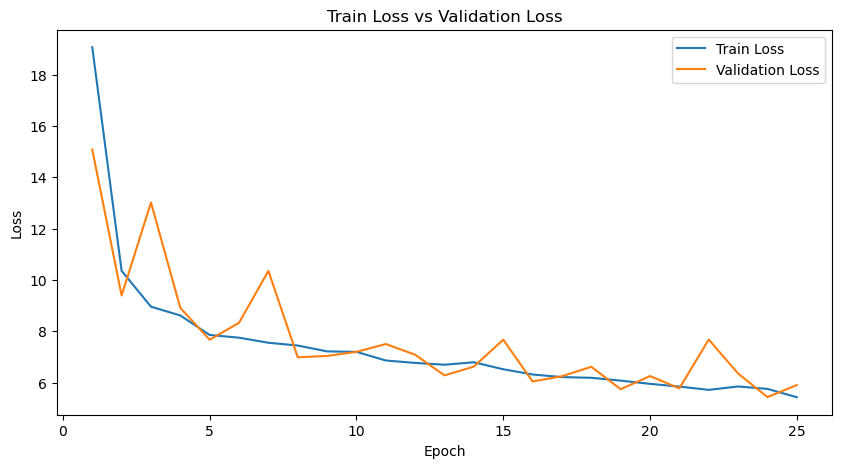

In [9]:
plot_losses(num_epochs, train_losses, val_losses)

In [10]:
model.eval()
test_loss = 0.0
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in test_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)
        outputs = model(images)
        loss = criterion(outputs, bboxes)
        test_loss += loss.item()

        test_loader_tqdm.set_postfix({"Test Loss": test_loss / len(test_loader)})

test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 220/220 [00:45<00:00,  4.82it/s, Test Loss=5.91]  

Test Loss: 5.905890859257092


In [11]:
save_images_with_bboxes(model, test_loader, device, dataset)

Images with bounding boxes have been saved to data\1_basic_output_imgs


In [12]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_loss,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_1_basic.pt"))